# Analysis of SpecletThree

This notebook analyzes the MCMC and ADVI fit of the SpecletThree model.
Below are some questions to address and aspects of the model to dig into:

1. Compare the parameter values between ADVI and MCMC.
2. Are there correlations between the parameter values?
3. Analyze the posterior predictions LOO values.
4. How do the model fits compare between the models with and without a covariate for *KRAS*?
5. Which genes change the most by the addition of the *KRAS* covariate?
6. How do the parameter values in this model compare to those from DepMap?

Currently, I am waiting for the model with the *KRAS* covariate to fit, so that is not included at the moment.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from theano import tensor as tt

In [3]:
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.io import cache_io, data_io
from src.loggers import logger
from src.modeling import pymc3_analysis as pmanal
from src.modeling import pymc3_sampling_api as pmapi
from src.models.speclet_three import SpecletThree
from src.plot.color_pal import FitMethodColors, ModelColors, SeabornColor, make_pal

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(
    gg.theme_bw()
    + gg.theme(
        figure_size=(4, 4),
        axis_ticks_major=gg.element_blank(),
        strip_background=gg.element_blank(),
    )
)
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 127
np.random.seed(RANDOM_SEED)

HDI_PROB = 0.89

eb = gg.element_blank()

## Build models and load MCMC results

In [5]:
model_name = "SpecletThree-debug"
sp3 = SpecletThree(
    model_name,
    root_cache_dir=cache_io.default_cache_dir(),
    debug=True,
    kras_cov=False,
)

sp3.build_model()
if sp3.cache_manager.mcmc_cache_exists():
    _ = sp3.mcmc_sample_model()
else:
    logger.error("Could not find model.")

[05/27/21 11:59:43] INFO     Calling `model_specification()` method.     ]8;id=1622131183.531783-568958;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:171

                    INFO     Beginning PyMC3 model specification.        ]8;id=1622131183.5366578-740179;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_three.py\speclet_three.py]8;;\:261

                    WARNING  Dropping data points of sgRNA that    ]8;id=1622131183.7803354-830412;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:125
                             map to multiple genes.

                    WARNING  Dropping data points with missing     ]8;id=1622131183.8082814-306102;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:131
                             copy number.

                    INFO     Getting Theano shared variables.            ]8;id=1622131183.872072-833155;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_three.py\speclet_three.py]8;;\:268

                    INFO     Creating PyMC3 model (non-centered          ]8;id=1622131183.879193-884100;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_three.py\speclet_three.py]8;;\:277
                             parameterization).

[05/27/21 11:59:58] INFO     ArvizCacheManager: MCMC cache exists.      ]8;id=1622131198.4890869-185467;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:273

                    INFO     ArvizCacheManager: MCMC cache exists.      ]8;id=1622131198.496205-659058;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:273

                    INFO     Returning results from cache.               ]8;id=1622131198.50134-772964;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:268

                    INFO     ArvizCacheManager: MCMC cache exists.      ]8;id=1622131198.5059571-147887;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:273

In [6]:
# model_name_kras = "SpecletThree-kras-debug"
# sp3_kras = SpecletThree(
#     model_name_kras,
#     root_cache_dir=cache_io.default_cache_dir(),
#     debug=True,
#     kras_cov=True,
# )

# sp3_kras.build_model()
# if sp3_kras.cache_manager.mcmc_cache_exists():
#     _ = sp3_kras.mcmc_sample_model()
# else:
#     logger.error("Could not find model.")

In [7]:
sp3.model

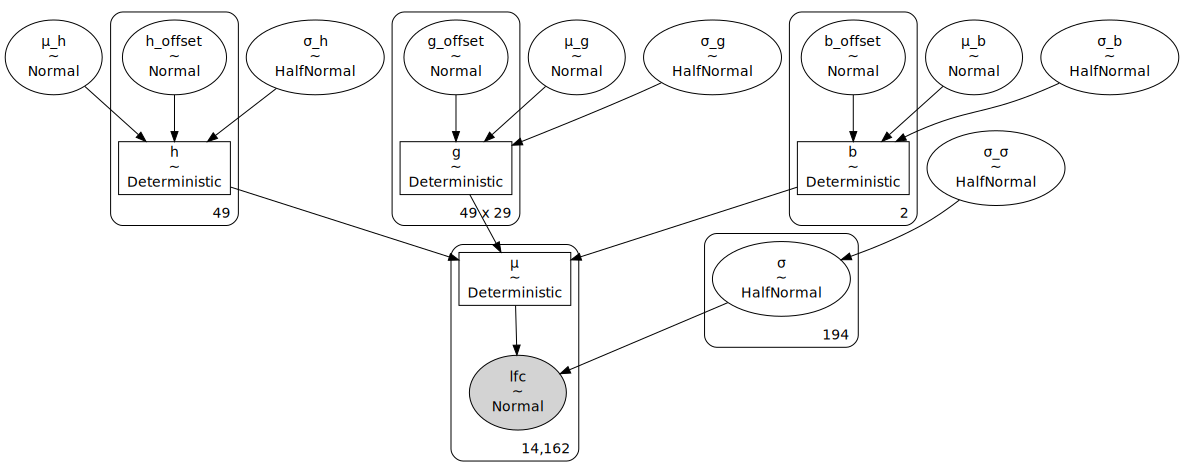

In [8]:
pm.model_to_graphviz(sp3.model)

In [9]:
# sp3_kras.model

In [10]:
# pm.model_to_graphviz(sp3_kras.model)

## Analyzing fit parameters

There are a few divergences, but the posteriors for the global hyperparameters of the consistent gene effect and cell line effect look great.
The only weird thing is there three of the chains look identical.
I think this is caused by something weird with the random seeds, so I will need to investigate further and possibly re-fit the models.

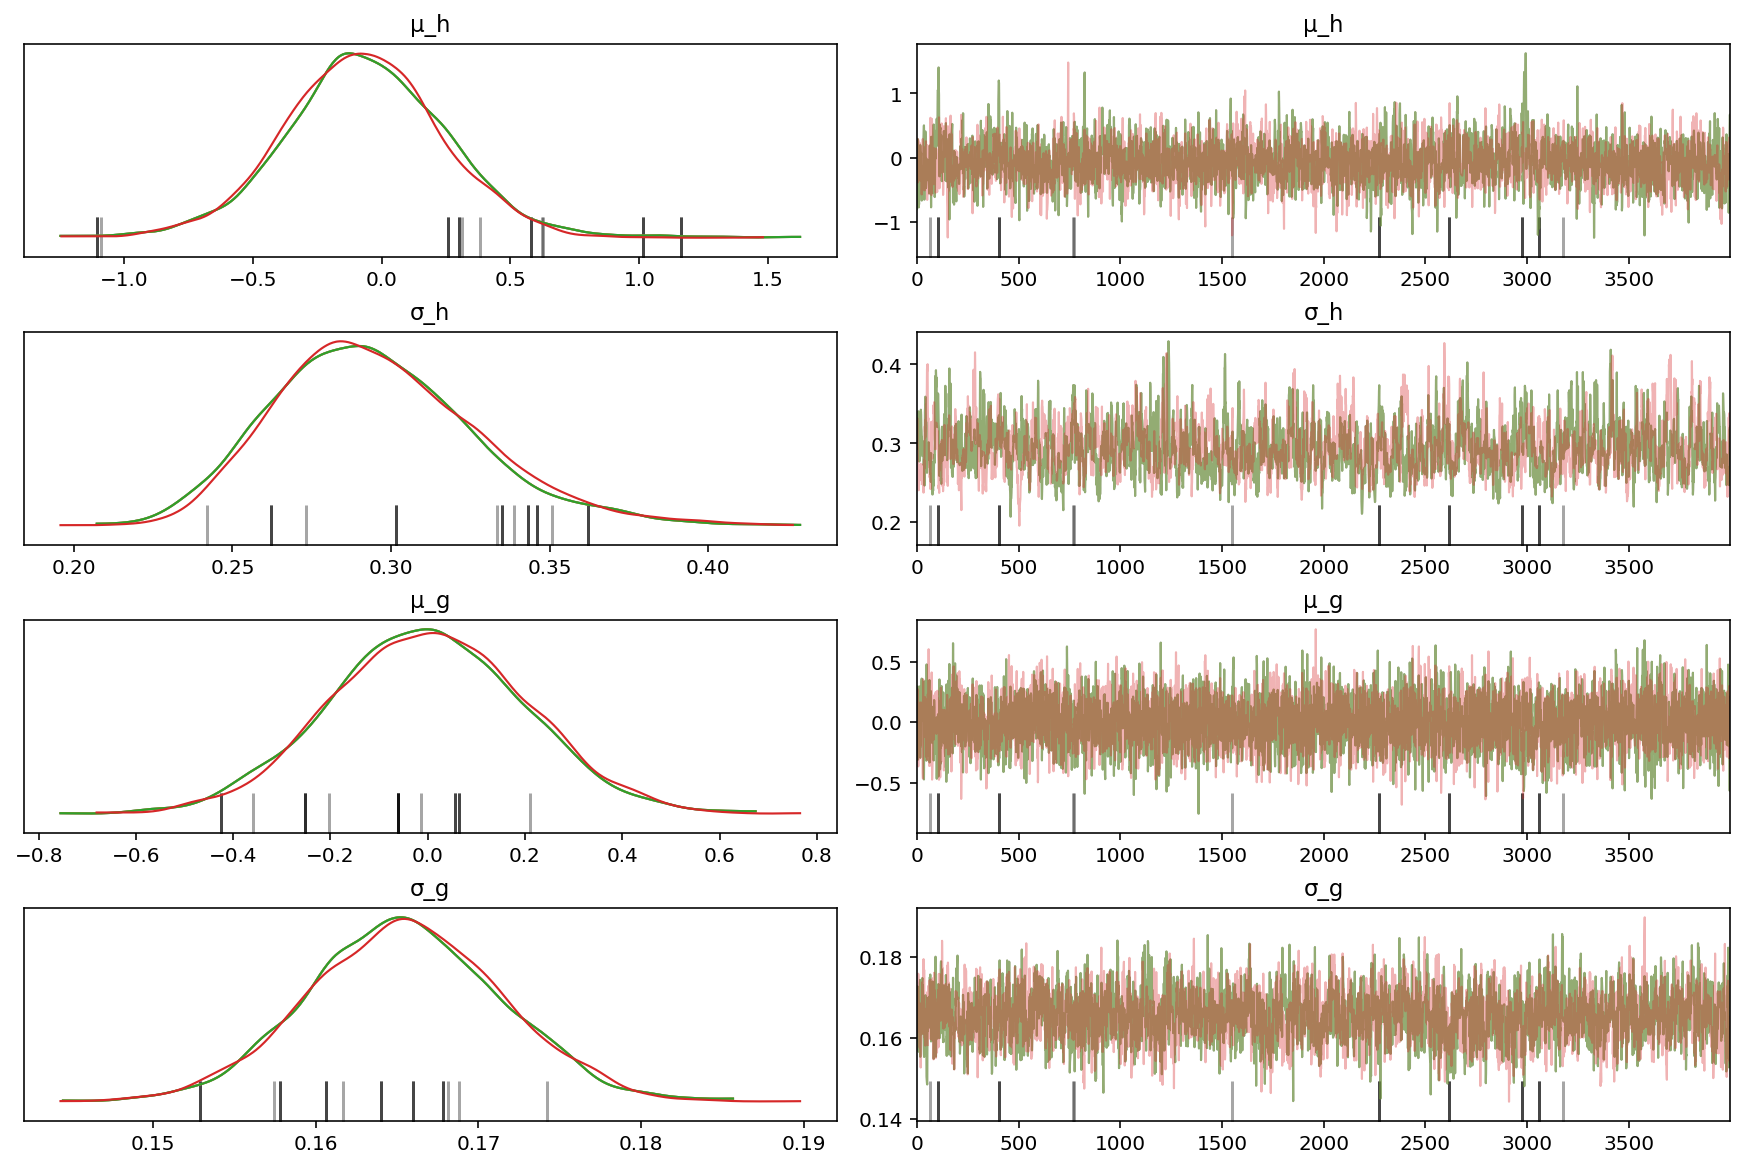

In [11]:
for sp3_model in [sp3]:  # , sp3_kras]:
    az.plot_trace(
        sp3_model.mcmc_results, var_names=["μ_h", "σ_h", "μ_g", "σ_g"], compact=False
    );

In [12]:
# az.plot_trace(sp3_kras.mcmc_results, var_names="μ_a", compact=False);

There is some good variance in the gene effects.
Most genes are centered at 0, but a few have stronger effects (e.g. *UQCRC1* and *EBAG9*).

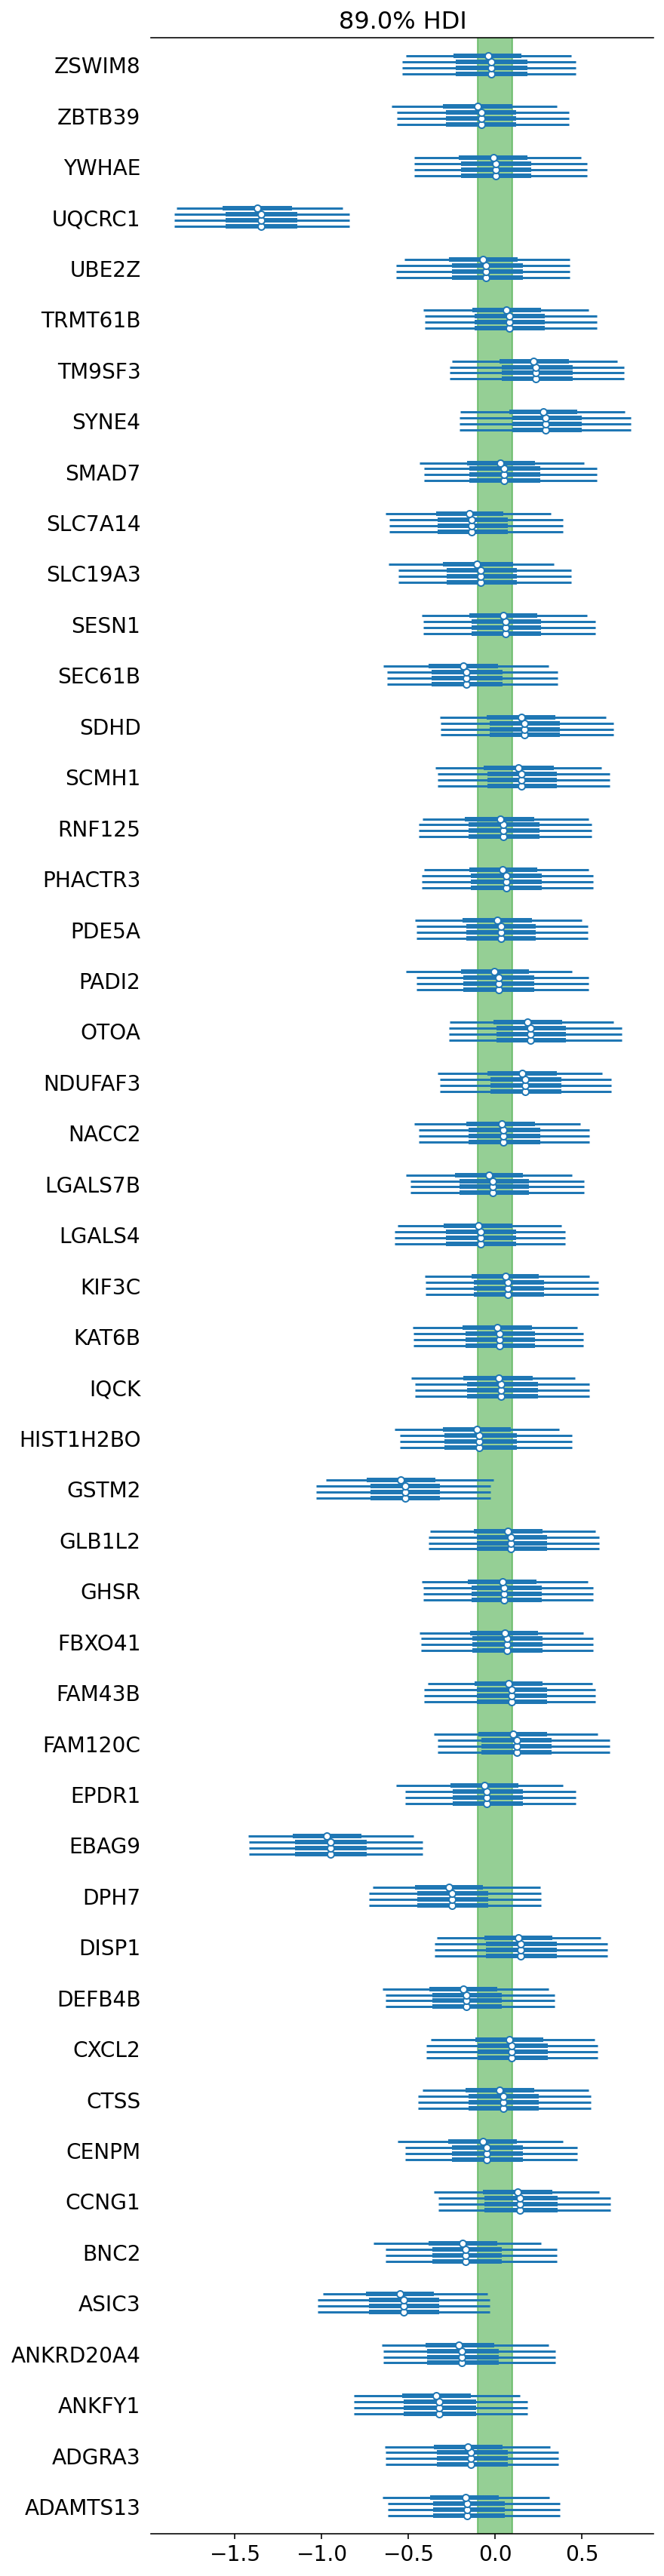

In [13]:
genes = sp3.data_manager.get_data().hugo_symbol.cat.categories
ax = az.plot_forest(
    sp3.mcmc_results, var_names="h", combined=False, hdi_prob=0.89, rope=(-0.1, 0.1)
)
ax[0].set_yticklabels(genes)
plt.show()

Inspecting the cell line effects per gene, there is some variance where some genes are more variable and some cell lines are more variable.

In [14]:
cell_lines = sp3.data_manager.get_data().depmap_id.cat.categories
genes = sp3.data_manager.get_data().hugo_symbol.cat.categories

cell_line_effects = (
    az.summary(sp3.mcmc_results, var_names="g", kind="stats", hdi_prob=HDI_PROB)
    .reset_index(drop=False)
    .pipe(
        pmanal.extract_matrix_variable_indices,
        col="index",
        idx1=genes,
        idx2=cell_lines,
        idx1name="hugo_symbol",
        idx2name="depmap_id",
    )
)

cell_line_effects.head()

,index,mean,sd,hdi_5.5%,hdi_94.5%,hugo_symbol,depmap_id
0,"g[0,0]",0.178,0.227,-0.189,0.541,ADAMTS13,ACH-000007
1,"g[0,1]",-0.036,0.219,-0.372,0.320,ADAMTS13,ACH-000009
2,"g[0,2]",0.069,0.220,-0.287,0.405,ADAMTS13,ACH-000202
3,"g[0,3]",-0.042,0.226,-0.401,0.321,ADAMTS13,ACH-000253
4,"g[0,4]",0.014,0.226,-0.343,0.377,ADAMTS13,ACH-000286


It would be interesting to hierarchically cluster the genes an cell lines for this heatmap.

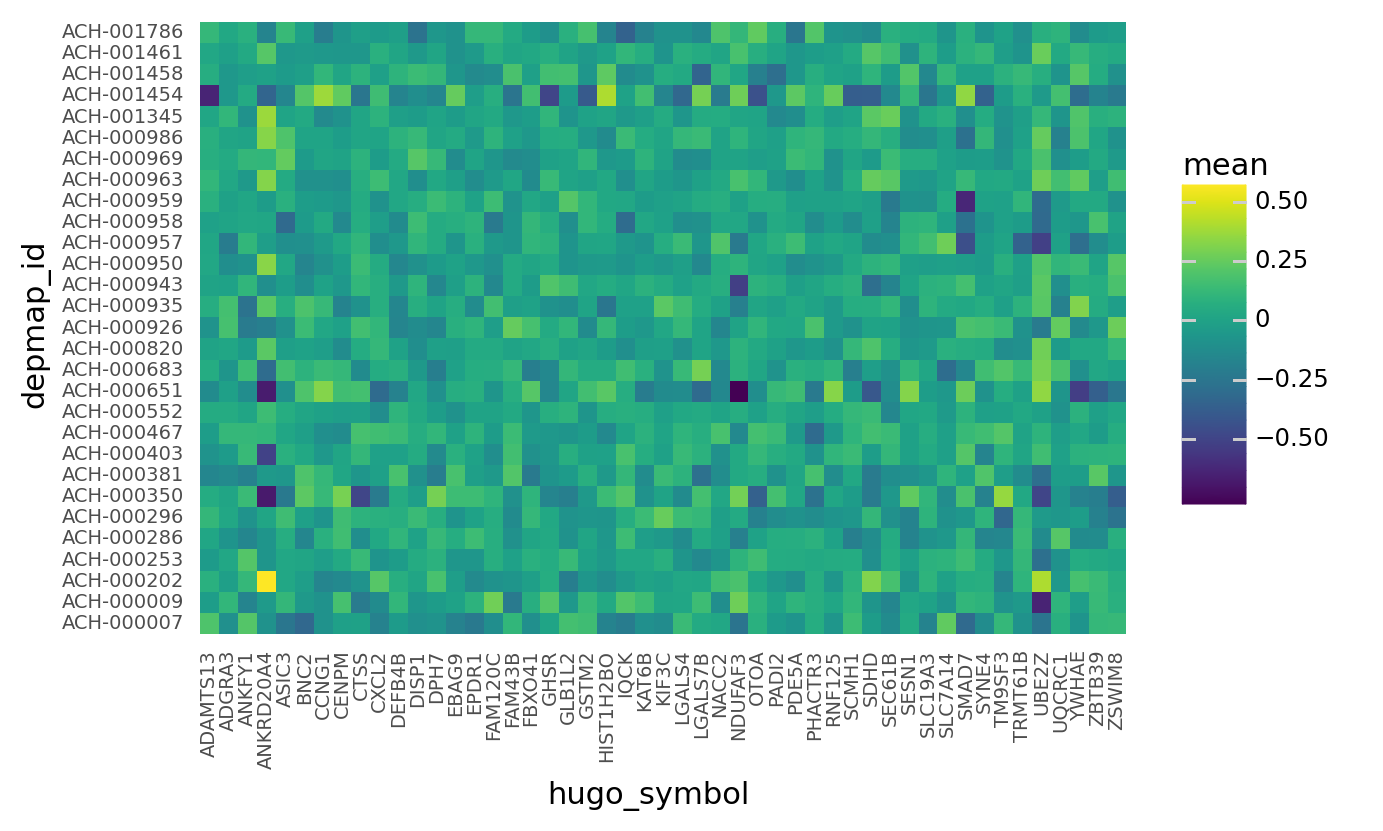

<ggplot: (8753779639293)>

In [15]:
(
    gg.ggplot(cell_line_effects, gg.aes(x="hugo_symbol", y="depmap_id"))
    + gg.geom_tile(gg.aes(fill="mean"), color=None)
    + gg.theme(
        axis_text_y=gg.element_text(size=7),
        axis_text_x=gg.element_text(angle=90, size=7),
        axis_ticks=eb,
        panel_grid=eb,
        panel_border=eb,
        figure_size=(6, 4),
    )
)

In [16]:
consistent_gene_effect = az.summary(
    sp3.mcmc_results, var_names="h", kind="stats", hdi_prob=HDI_PROB
)
consistent_gene_effect["hugo_symbol"] = genes
consistent_gene_effect.head()

,mean,sd,hdi_5.5%,hdi_94.5%,hugo_symbol
h[0],-0.024,0.319,-0.520,0.466,ADAMTS13
h[1],-0.085,0.319,-0.552,0.429,ADGRA3
h[2],0.003,0.319,-0.485,0.499,ANKFY1
h[3],-1.348,0.323,-1.833,-0.840,ANKRD20A4
h[4],-0.051,0.319,-0.557,0.428,ASIC3


Below, I dig further into the gene *ANKRD20A4* because it showed a high degree of variance across cell lines in the above heatmap.
I plot the real LFC values as box-plots, the consistent gene effect in red (with a 89% CI), and the cell line effects in blue (with 89% CI).
The consistent gene effect was added to the cell line effect.
The shrinkage toward the mean effect for the gene is very strong.

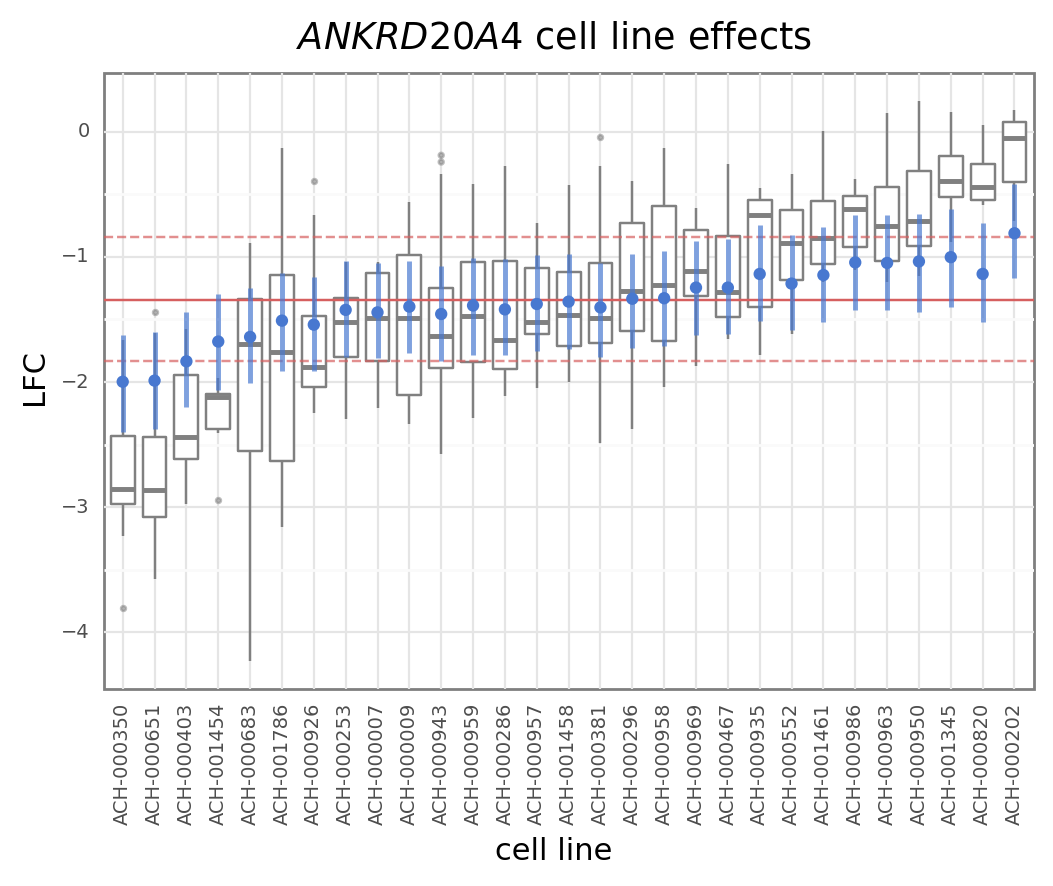

<ggplot: (8753779553780)>

In [17]:
goi = "ANKRD20A4"
achilles_data_df = sp3.data_manager.get_data()
achilles_data_df = achilles_data_df.copy()[achilles_data_df.hugo_symbol == goi]

# Set order of DepMapID in increasing avg. LFC.
depmap_id_order = (
    achilles_data_df.groupby(["depmap_id"])["lfc"]
    .mean()
    .reset_index(drop=False)
    .sort_values("lfc")
    .depmap_id.to_list()
)
achilles_data_df["depmap_id"] = pd.Categorical(
    achilles_data_df["depmap_id"].values, ordered=True, categories=depmap_id_order
)


# Get consistent gene effect to plot as horizontal line.
goi_gene_effect = consistent_gene_effect[consistent_gene_effect.hugo_symbol == goi]
goi_avg = goi_gene_effect[["mean"]].values[0]
goi_hdi = goi_gene_effect[["hdi_5.5%", "hdi_94.5%"]].values[0]


# Cell line effect.
goi_cell_line_effect = cell_line_effects[cell_line_effects.hugo_symbol == goi][
    ["mean", "hdi_5.5%", "hdi_94.5%", "depmap_id"]
].reset_index(drop=True)
goi_cell_line_effect["depmap_id"] = pd.Categorical(
    goi_cell_line_effect["depmap_id"].values, ordered=True, categories=depmap_id_order
)
for c in ["mean", "hdi_5.5%", "hdi_94.5%"]:
    goi_cell_line_effect[c] = goi_cell_line_effect[c] + goi_avg


(
    gg.ggplot(achilles_data_df, gg.aes(x="depmap_id", y="lfc"))
    + gg.geom_boxplot(color="gray", outlier_size=0.5, outlier_alpha=0.5)
    + gg.geom_hline(yintercept=goi_avg[0], color=SeabornColor.red)
    + gg.geom_hline(
        yintercept=goi_hdi, color=SeabornColor.red, linetype="--", alpha=0.7
    )
    # + gg.geom_rect(
    #     gg.aes(xmin=0, xmax=np.inf, ymin=goi_hdi[0], ymax=goi_hdi[1], alpha=0.2),
    #     fill=SeabornColor.red,
    # )
    + gg.geom_point(
        gg.aes(x="depmap_id", y="mean"),
        data=goi_cell_line_effect,
        color=SeabornColor.blue,
    )
    + gg.geom_linerange(
        gg.aes(x="depmap_id", ymin="hdi_5.5%", ymax="hdi_94.5%", y="mean"),
        data=goi_cell_line_effect,
        color=SeabornColor.blue,
        size=1,
        alpha=0.7,
    )
    + gg.scale_alpha_identity()
    + gg.theme(
        axis_text_y=gg.element_text(size=7),
        axis_text_x=gg.element_text(angle=90, size=7),
        axis_ticks=eb,
        figure_size=(6, 4),
    )
    + gg.labs(x="cell line", y="LFC", title=f"${goi}$ cell line effects")
)

### Comparing against CERES

Below, I import the CERES gene effect data and compare it to the results from SpecletThree.

In [18]:
depmap_gene_effect = pd.read_csv(
    data_io.data_path(data_io.DataFile.achilles_gene_effect)
)
depmap_gene_effect = depmap_gene_effect[depmap_gene_effect.hugo_symbol.isin(genes)]
depmap_gene_effect = depmap_gene_effect[depmap_gene_effect.depmap_id.isin(cell_lines)]
depmap_gene_effect = depmap_gene_effect.reset_index(drop=True)
depmap_gene_effect.head()

,depmap_id,hugo_symbol,gene_effect,gene_effect_unscaled
0,ACH-000007,ADAMTS13,0.207021,0.440897
1,ACH-000009,ADAMTS13,-0.257312,-0.189547
2,ACH-000202,ADAMTS13,0.119178,0.207203
3,ACH-000253,ADAMTS13,-0.122489,-0.036306
4,ACH-000286,ADAMTS13,-0.005170,0.166132


In [19]:
cell_line_effects.head()

,index,mean,sd,hdi_5.5%,hdi_94.5%,hugo_symbol,depmap_id
0,"g[0,0]",0.178,0.227,-0.189,0.541,ADAMTS13,ACH-000007
1,"g[0,1]",-0.036,0.219,-0.372,0.320,ADAMTS13,ACH-000009
2,"g[0,2]",0.069,0.220,-0.287,0.405,ADAMTS13,ACH-000202
3,"g[0,3]",-0.042,0.226,-0.401,0.321,ADAMTS13,ACH-000253
4,"g[0,4]",0.014,0.226,-0.343,0.377,ADAMTS13,ACH-000286


In [20]:
combined_cell_line_effect = (
    cell_line_effects[["mean", "hdi_5.5%", "hdi_94.5%", "hugo_symbol", "depmap_id"]]
    .rename(
        columns={
            "mean": "sp_cell_mean",
            "hdi_5.5%": "sp_hdi_5.5%",
            "hdi_94.5%": "sp_hdi_94.5%",
        }
    )
    .merge(
        consistent_gene_effect[["hugo_symbol", "mean"]].rename(
            columns={"mean": "sp_gene_mean"}
        ),
        on=["hugo_symbol"],
    )
    .assign(sp_total_effect=lambda d: d.sp_cell_mean + d.sp_gene_mean)
    .merge(depmap_gene_effect, how="inner", on=["hugo_symbol", "depmap_id"])
)

combined_cell_line_effect.head()

,sp_cell_mean,sp_hdi_5.5%,sp_hdi_94.5%,hugo_symbol,depmap_id,sp_gene_mean,sp_total_effect,gene_effect,gene_effect_unscaled
0,0.178,-0.189,0.541,ADAMTS13,ACH-000007,-0.024,0.154,0.207021,0.440897
1,-0.036,-0.372,0.320,ADAMTS13,ACH-000009,-0.024,-0.060,-0.257312,-0.189547
2,0.069,-0.287,0.405,ADAMTS13,ACH-000202,-0.024,0.045,0.119178,0.207203
3,-0.042,-0.401,0.321,ADAMTS13,ACH-000253,-0.024,-0.066,-0.122489,-0.036306
4,0.014,-0.343,0.377,ADAMTS13,ACH-000286,-0.024,-0.010,-0.005170,0.166132


The first comparison is to just the cell line-specific effect, but there is a high degree of disagreement.
I looked into it further, and the genes with the largest disagreement were those with strong consistent gene effects.

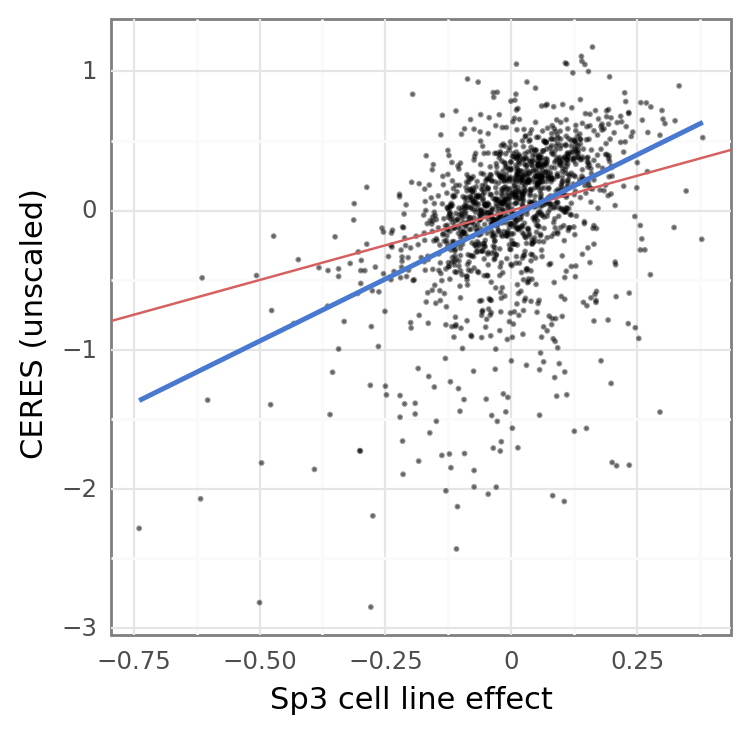

<ggplot: (8753779406309)>

In [21]:
(
    gg.ggplot(
        combined_cell_line_effect, gg.aes(x="sp_cell_mean", y="gene_effect_unscaled")
    )
    + gg.geom_point(size=0.2, alpha=0.4)
    + gg.geom_abline(slope=1, intercept=0, color=SeabornColor.red)
    + gg.geom_smooth(method="lm", formula="y~x", se=False, color=SeabornColor.blue)
    + gg.labs(x="Sp3 cell line effect", y="CERES (unscaled)")
)

The following plot compares the CERES gene effect to the consistent gene effect plus the cell line-specific effect estimates by SpecletThree.
There is a high degree of concordance, but the points do lie along the 1:1 diagonal.
This is probably because the values from SpecletThree are pulled towards the mean of 0, shrinking the estimates.

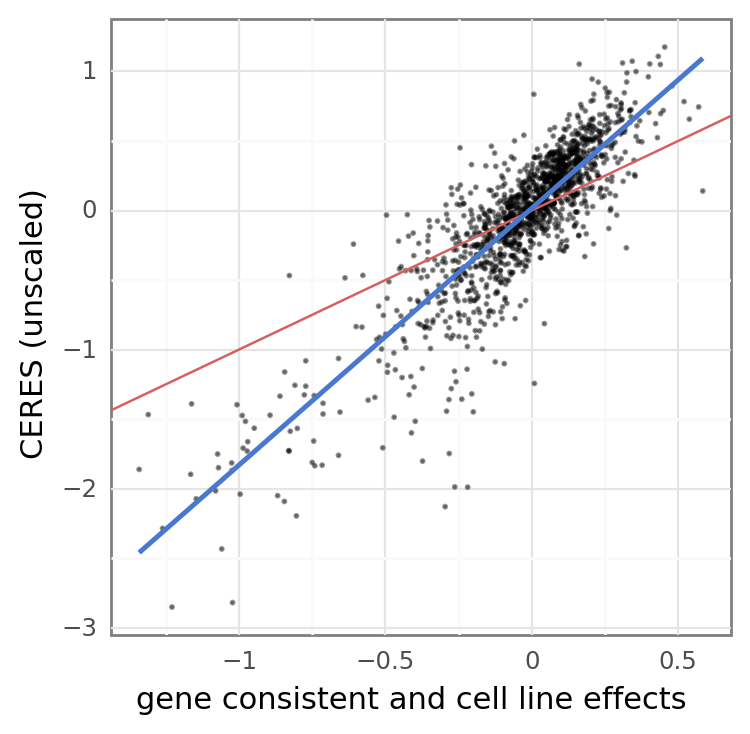

<ggplot: (8753779075160)>

In [22]:
(
    gg.ggplot(
        combined_cell_line_effect, gg.aes(x="sp_total_effect", y="gene_effect_unscaled")
    )
    + gg.geom_point(size=0.2, alpha=0.4)
    + gg.geom_abline(slope=1, intercept=0, color=SeabornColor.red)
    + gg.geom_smooth(method="lm", formula="y~x", se=False, color=SeabornColor.blue)
    + gg.labs(x="gene consistent and cell line effects", y="CERES (unscaled)")
)

### Batch effects

In this subsample, there does not appear to be a strong batch effect.

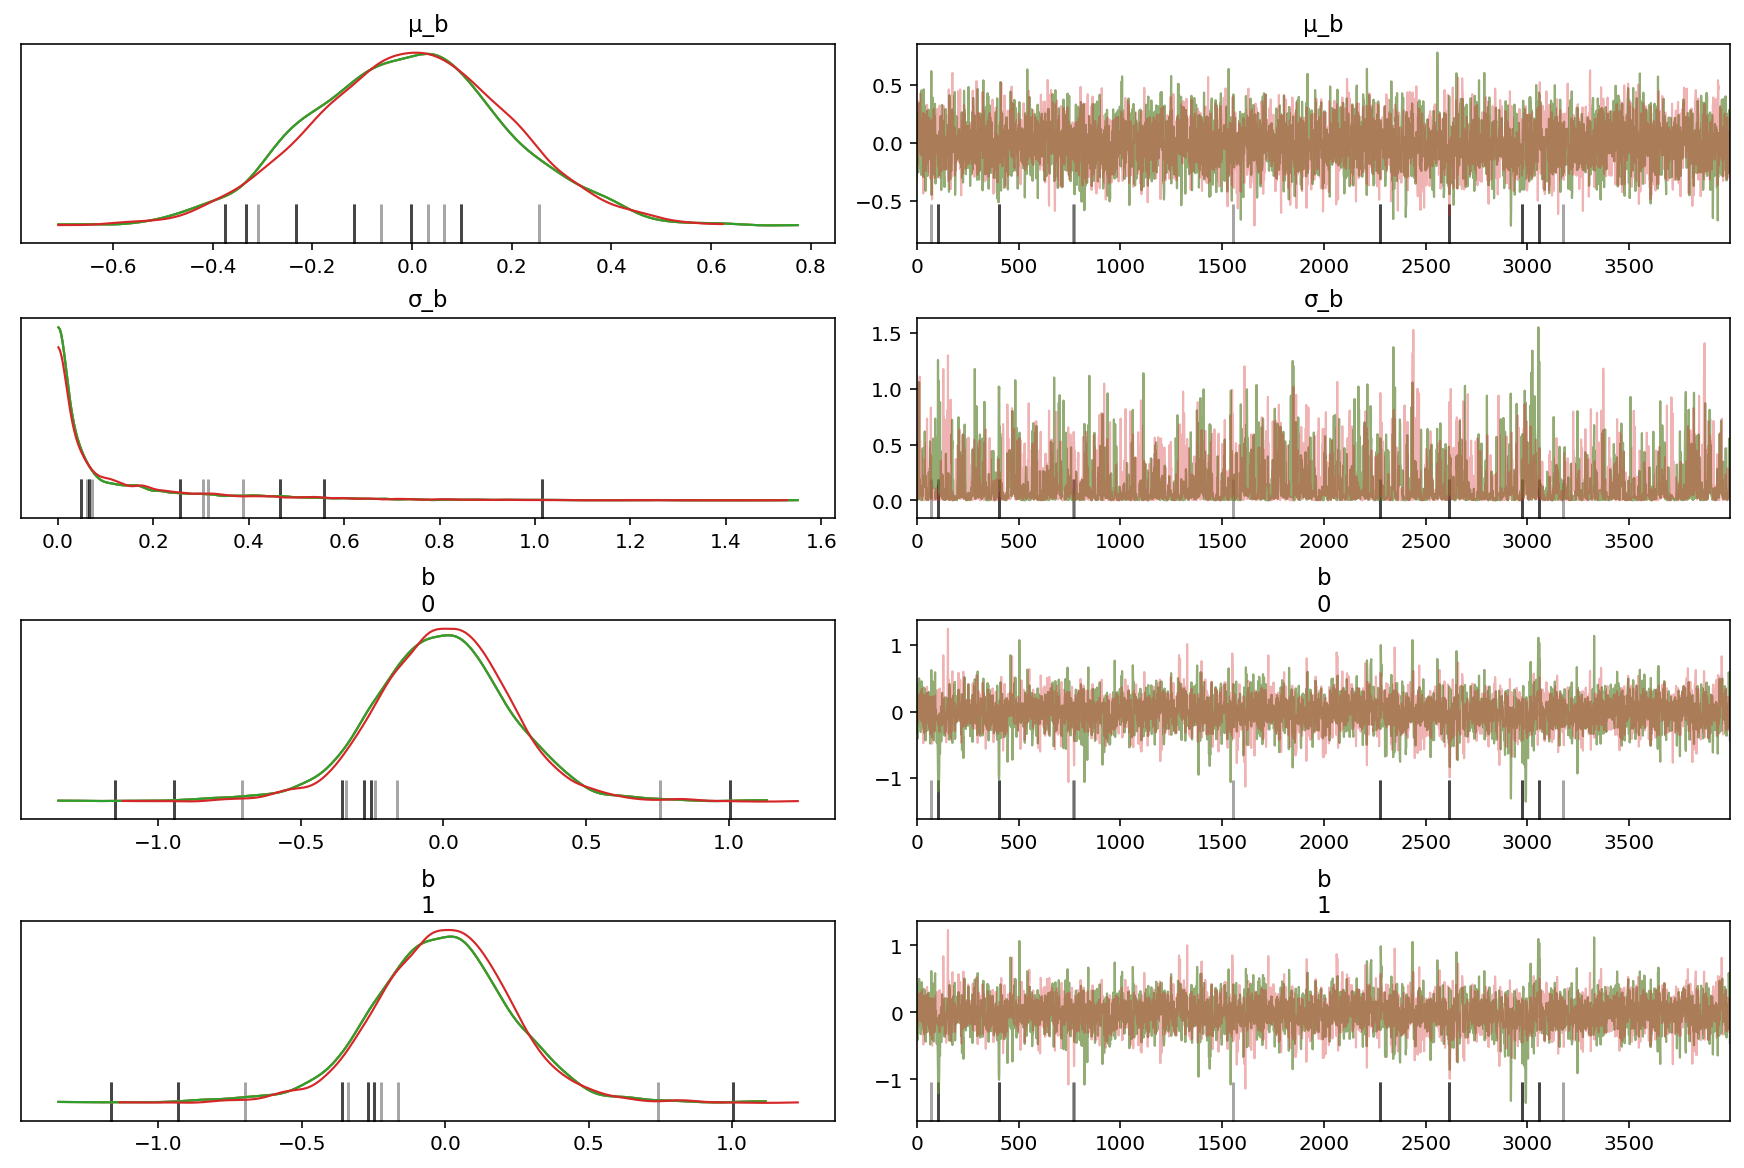

In [23]:
az.plot_trace(sp3.mcmc_results, var_names=["μ_b", "σ_b", "b"], compact=False);

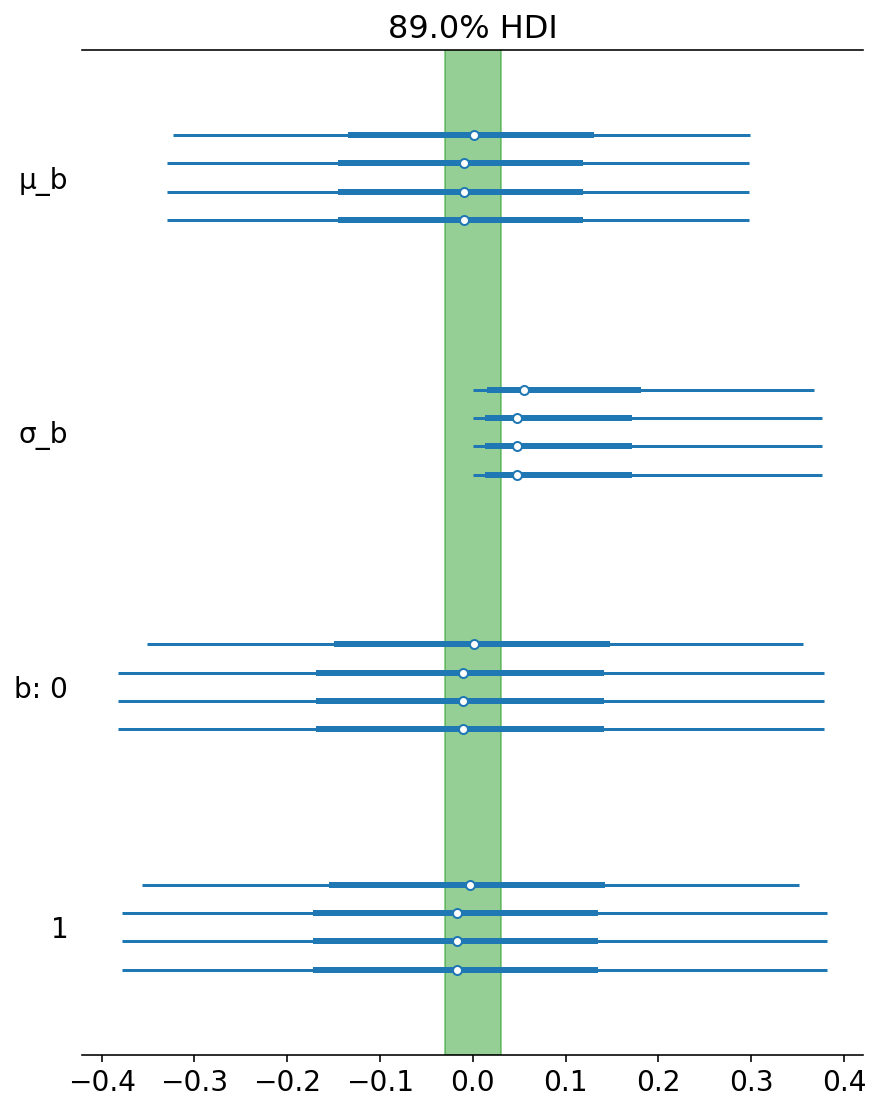

In [24]:
az.plot_forest(
    sp3.mcmc_results,
    var_names=["μ_b", "σ_b", "b"],
    hdi_prob=HDI_PROB,
    rope=(-0.03, 0.03),
);

## Analysis of ADVI fit

In [25]:
if sp3.cache_manager.advi_cache_exists():
    _, advi_approx = sp3.advi_sample_model()
else:
    logger.error("Could not find model.")

[05/27/21 12:00:27] INFO     ArvizCacheManager: ADVI cache exists.      ]8;id=1622131227.0600243-709335;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:277

/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


[05/27/21 12:00:30] INFO     ArvizCacheManager: ADVI cache exists.      ]8;id=1622131230.15724-372864;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:277

                    INFO     Returning results from cache.               ]8;id=1622131230.1609426-684053;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:394

                    INFO     ArvizCacheManager: ADVI cache exists.      ]8;id=1622131230.1641488-389239;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:277

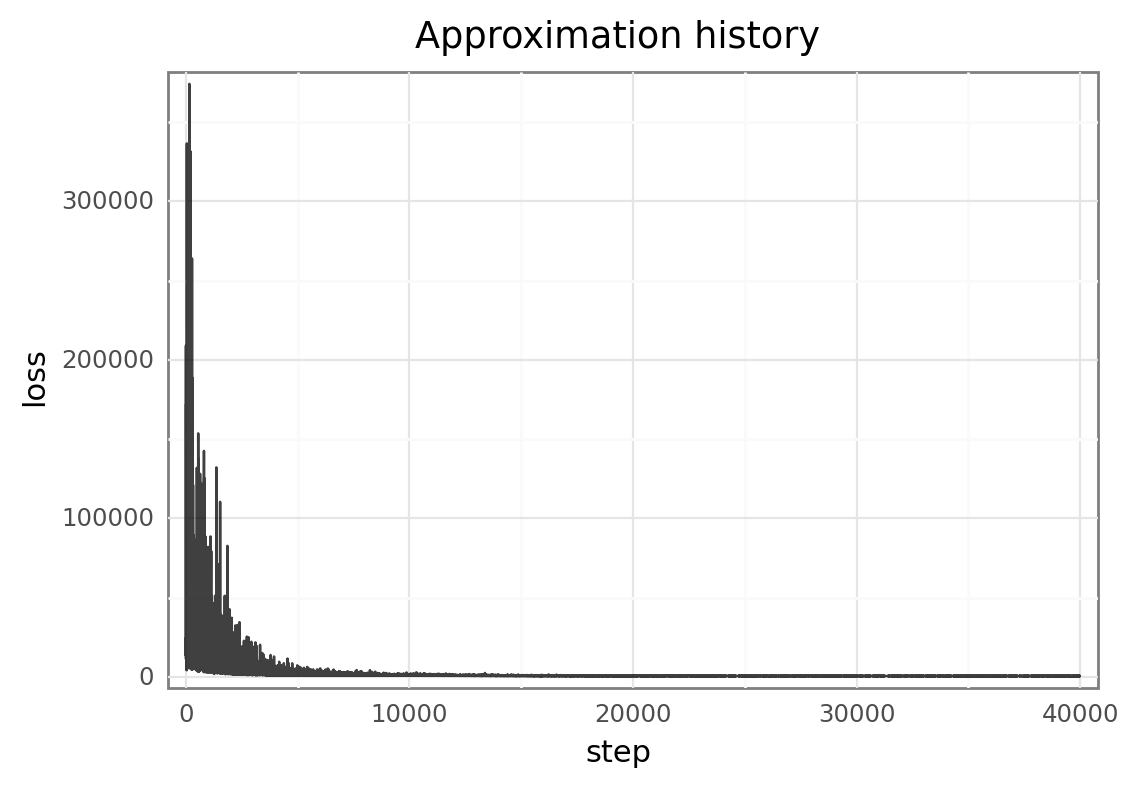

<ggplot: (8753769503952)>

In [26]:
pmanal.plot_vi_hist(advi_approx) + gg.theme(figure_size=(6, 4))

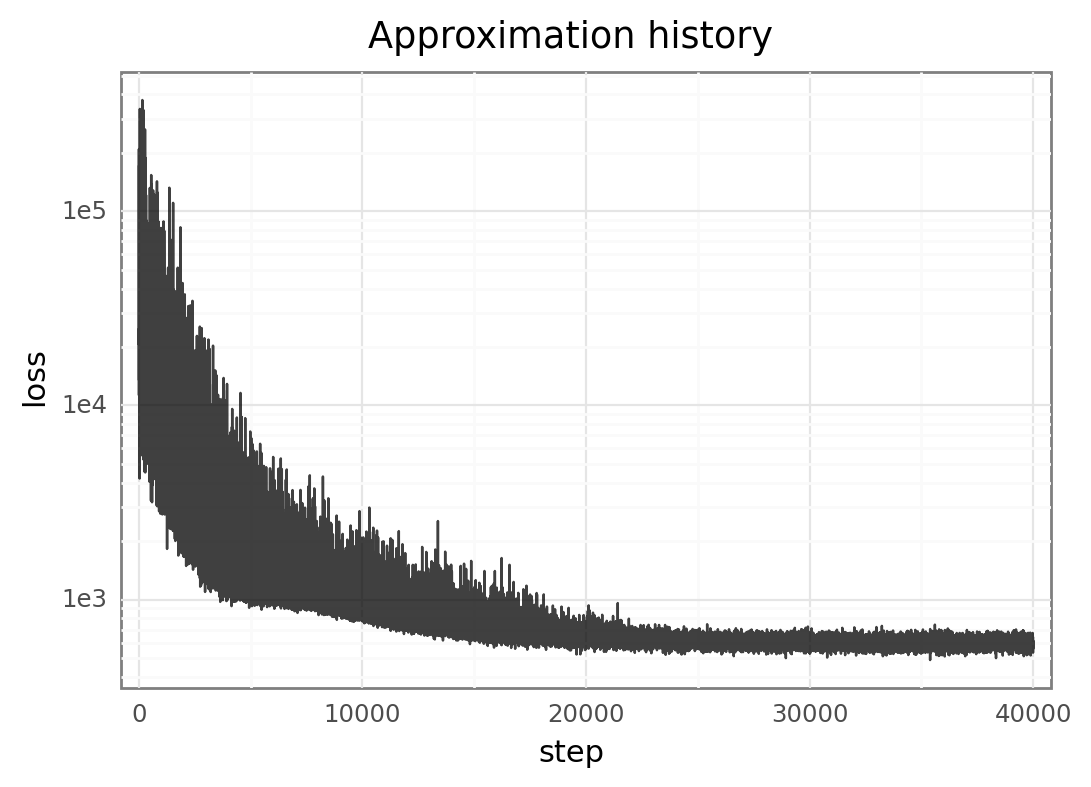

<ggplot: (8753778871131)>

In [27]:
pmanal.plot_vi_hist(advi_approx) + gg.scale_y_log10() + gg.theme(figure_size=(6, 4))

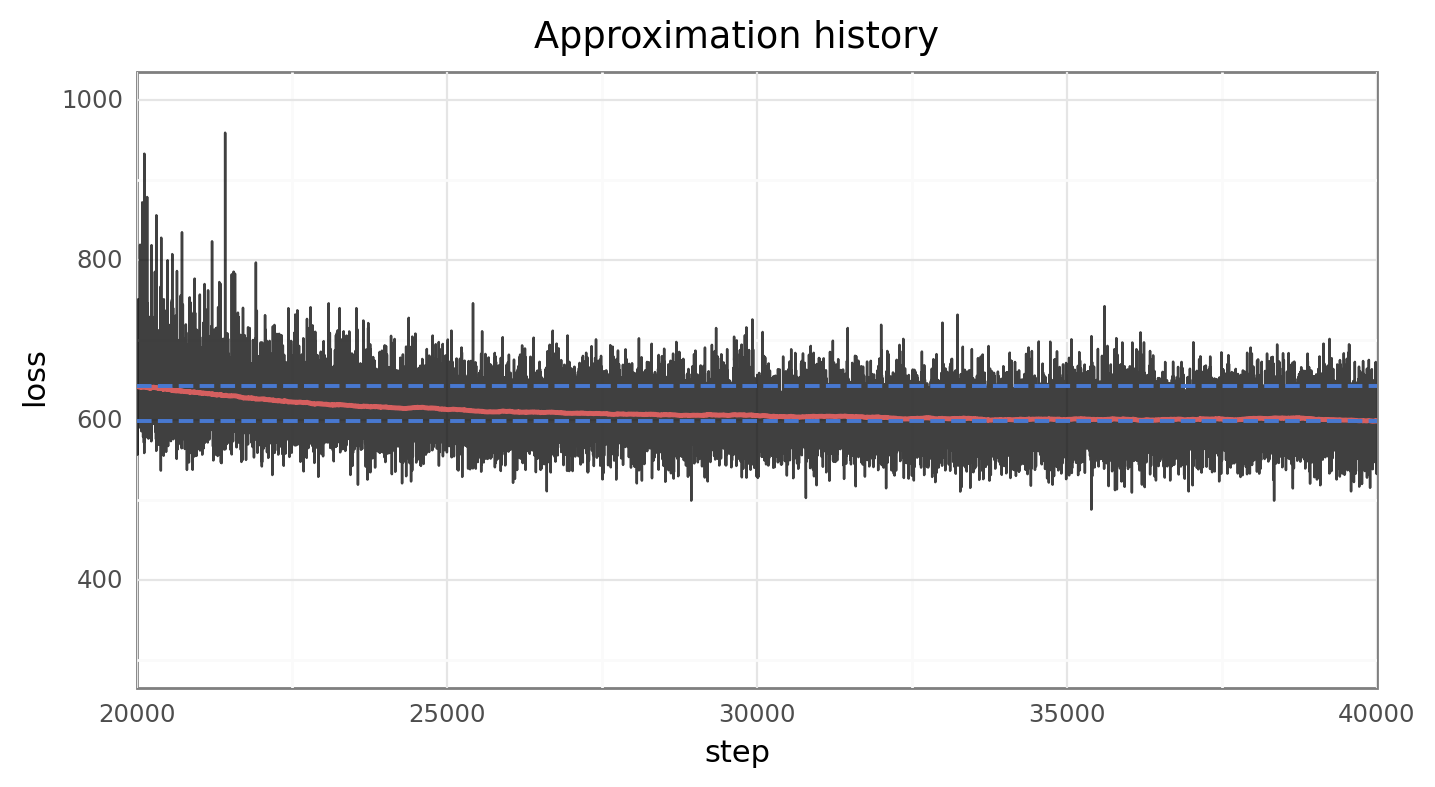

<ggplot: (8753769203706)>

In [28]:
limits = (20000, 40000)
window = 500
hist_sliding_avg = [
    np.mean(advi_approx.hist[(i - window) : (i + window)]) for i in range(*limits)
]
df = pd.DataFrame({"x": range(*limits), "y": hist_sliding_avg})

(
    pmanal.plot_vi_hist(advi_approx)
    + gg.geom_line(gg.aes(x="x", y="y"), data=df, color=SeabornColor.red, size=1)
    + gg.geom_hline(
        yintercept=(hist_sliding_avg[0], hist_sliding_avg[-1]),
        color=SeabornColor.blue,
        linetype="--",
        size=0.8,
    )
    + gg.scale_x_continuous(limits=limits, expand=(0, 0))
    + gg.scale_y_continuous(limits=(300, 1000))
    + gg.theme(figure_size=(8, 4))
)

In [29]:
advi_consistent_gene_effect = az.summary(
    sp3.advi_results[0], var_names="h", kind="stats", hdi_prob=HDI_PROB
).assign(hugo_symbol=genes)

Compared to the results from fitting with MCMC, the ADVI parameter estimates do not capture the variance well. This may be cause by two factors:

1. the ADVI fitting it continuing for too long
2. I am currently using `MeanField` ADVI, but `FullRank` may be able to better capture the variance (at higher computational costs).

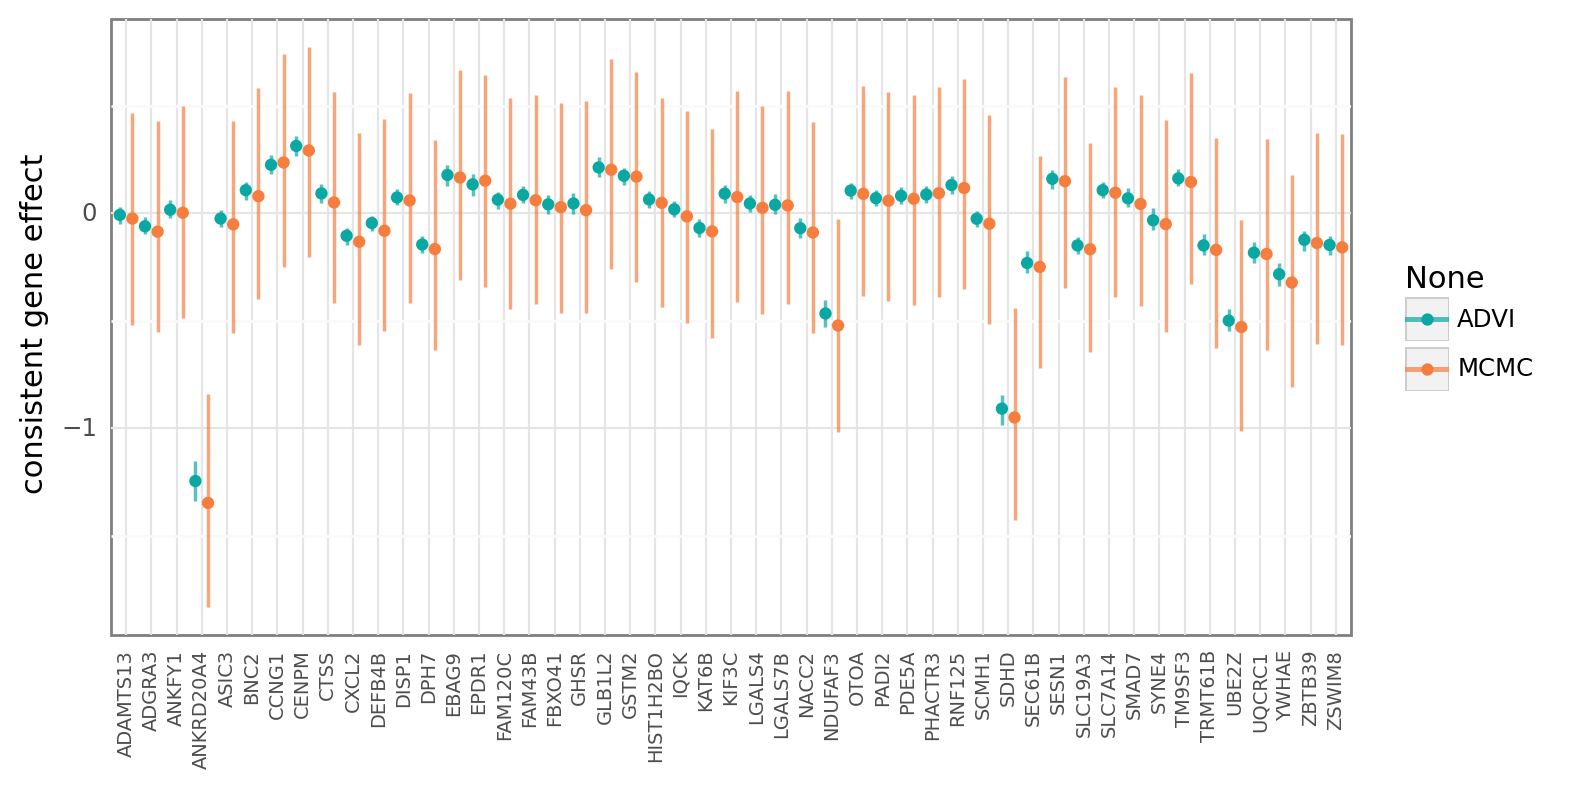

<ggplot: (8753769617908)>

In [30]:
combined_consistent_gene_effect = pd.concat(
    [
        advi_consistent_gene_effect.assign(method="ADVI"),
        consistent_gene_effect.assign(method="MCMC"),
    ]
)

pos = gg.position_dodge(width=1)
pal = make_pal(FitMethodColors)
pal = {k.replace("pymc3_", "").upper(): v for k, v in pal.items()}

(
    gg.ggplot(
        combined_consistent_gene_effect,
        gg.aes(x="hugo_symbol", y="mean", color="method"),
    )
    + gg.geom_linerange(
        gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), position=pos, size=0.7, alpha=0.7
    )
    + gg.geom_point(position=pos)
    + gg.scale_color_manual(values=pal)
    + gg.theme(axis_text_x=gg.element_text(angle=90, size=7), figure_size=(8, 4))
    + gg.labs(x=None, y="consistent gene effect", color=None)
)

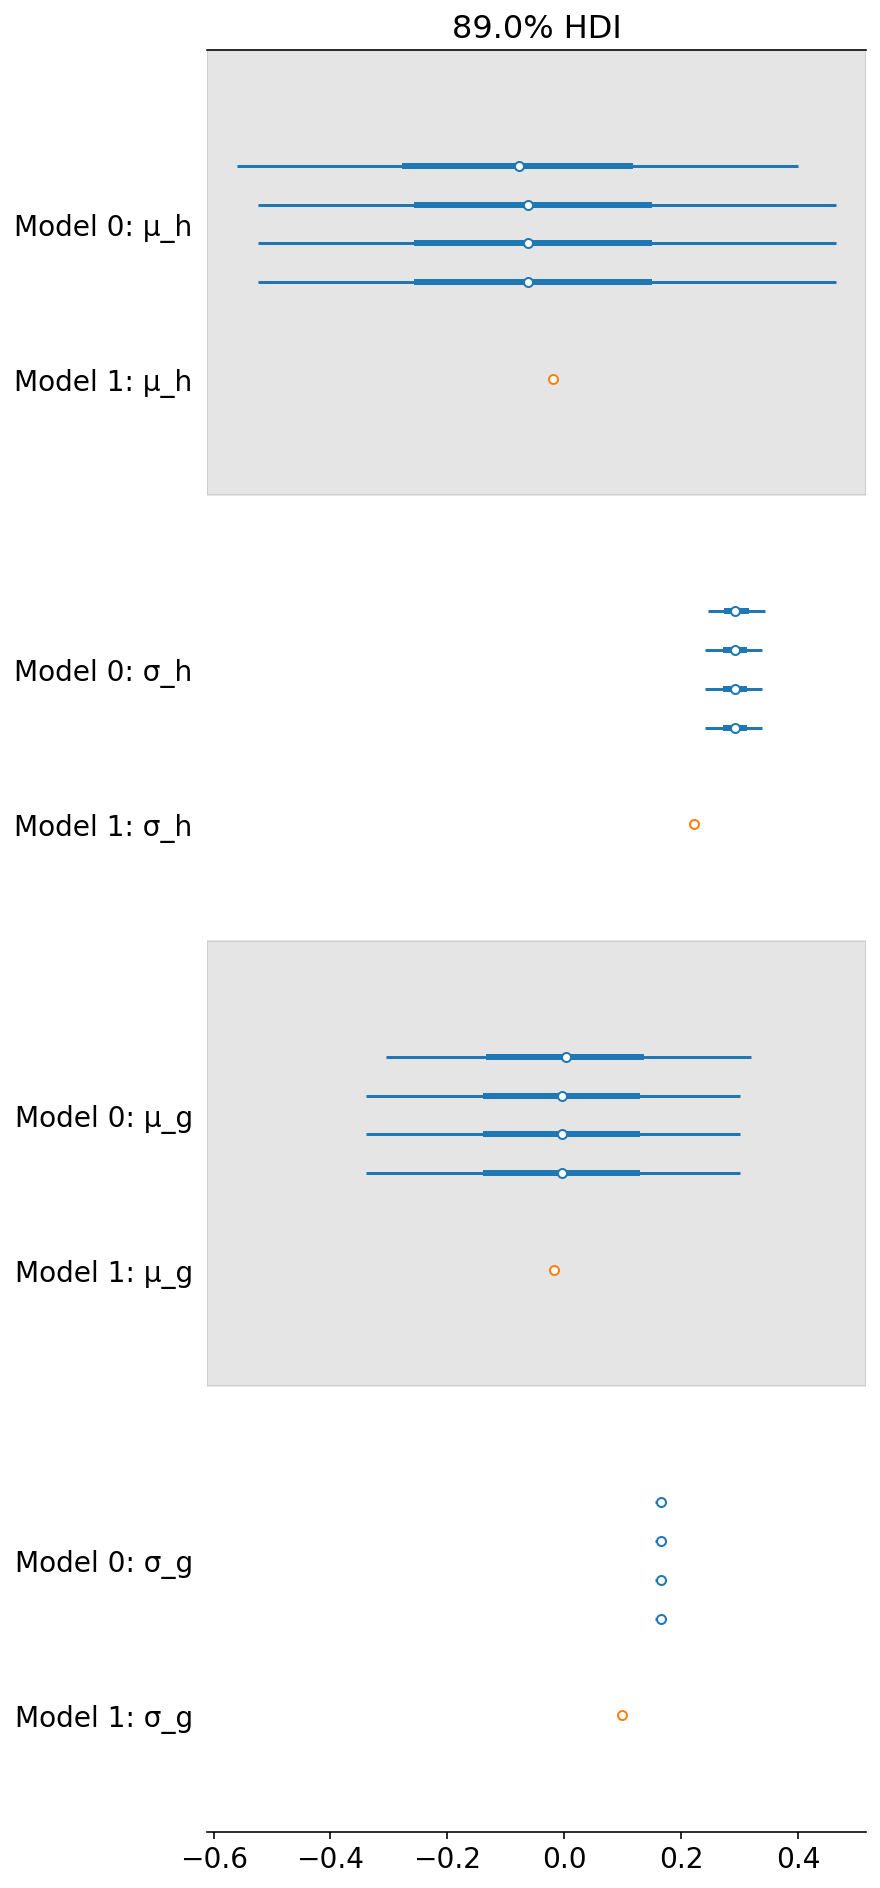

In [31]:
az.plot_forest(
    [sp3.mcmc_results, sp3.advi_results[0]],
    var_names=["μ_h", "σ_h", "μ_g", "σ_g"],
    hdi_prob=HDI_PROB,
);

---

In [32]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.91 minutes


In [33]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-05-27

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.22.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-230.o2.rc.hms.harvard.edu

Git branch: noncentered-reparam

re        : 2.2.1
pymc3     : 3.11.2
matplotlib: 3.4.1
numpy     : 1.20.2
pandas    : 1.2.3
plotnine  : 0.8.0
theano    : 1.0.5
arviz     : 0.11.2
seaborn   : 0.11.1

